#Task 1

#Problem Statement

Report a plot of $\epsilon$ where
$$ \epsilon = min || |\psi(\theta)> - |\phi> ||$$
$\psi(\theta)$ is the output of the Paramtertised Quantum Circuit.

In [ ]:
!pip install qiskit
!pip install pylatexenc

In [3]:
#Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import qiskit as q

Defining necessary functions to make the circuit.

In [5]:
N_qub = 4

#Defining helper functions to create the circuits
def evenLayer(circ, layer_num, theta):
  circ.rz(theta[layer_num,0],0)
  circ.rz(theta[layer_num,1],1)
  circ.rz(theta[layer_num,2],2)
  circ.rz(theta[layer_num,3],3)

  #Full entanglement
  circ.cz(0,1)
  circ.cz(0,2)
  circ.cz(0,3)
  circ.cz(1,2)
  circ.cz(1,3)
  circ.cz(2,3)

def oddLayer(circ, layer_num, theta):
  circ.rx(theta[layer_num,0],0)
  circ.rx(theta[layer_num,1],1)
  circ.rx(theta[layer_num,2],2)
  circ.rx(theta[layer_num,3],3)

def createCirc(theta):
  theta2 = theta.reshape((2*N_layer, N_qub))
  qr = q.QuantumRegister(4, name="q")
  cr = q.ClassicalRegister(4, name='c')
  circ = q.QuantumCircuit(qr, cr)
  ##Adding layers
  for i in range(N_layer):
    oddLayer(circ, 2*(i-1),theta2)
    evenLayer(circ, 2*i-1,theta2)
  return circ

The statevector simulator was used as we need to optimize with respect to a state.

(8,) 8
Output Error: 0.7706005104006234
(16,) 16
Output Error: 0.4338264390398657
(24,) 24
Output Error: 0.22292720273515784
(32,) 32
Output Error: 0.413457092972647
(40,) 40
Output Error: 0.17040070730146145
(48,) 48
Output Error: 0.11680995396455342
(56,) 56
Output Error: 0.17209236082308935
(64,) 64
Output Error: 0.13048855955593391
(72,) 72
Output Error: 0.05093344187168222


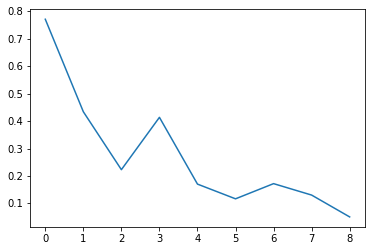

In [7]:
N_qub = 4
target_vec = np.asarray(q.quantum_info.random_statevector(16, seed = 10)._data)
backend = q.Aer.get_backend("statevector_simulator")

N_layer = 1 ##GLOBALLY USED in createCirc function
N_layer_max = 10
max_iter = 1500
#Variable to store error in all the layers, to check convergence
error = []

#Defining the objective function
def objective_function(theta):
    qc = createCirc(theta) #The global N_layer value is used
    result = q.execute(qc, backend).result()
   
    cost = (np.sum((abs(np.asarray(result.get_statevector(qc)) - target_vec))**2))**0.5
    error.append(cost)
    return cost

from qiskit.aqua.components.optimizers import COBYLA

#Array for storing minimum error of each layer
cost_arr = np.zeros((N_layer_max-1,))
optimizer = COBYLA(maxiter=max_iter)

#Running the simulation
while N_layer<N_layer_max:
  #Parameter
  theta = np.random.uniform(0,2*np.pi, (2*N_layer*N_qub))
  print(theta.shape, (2*N_layer*N_qub))
  ret = optimizer.optimize(num_vars=(2*N_layer*N_qub), objective_function=objective_function, initial_point=theta)

  #Getting final result
  qc = createCirc(ret[0])
  result = q.execute(qc, backend).result()
  cost_arr[N_layer-1] = (np.sum((abs(np.asarray(result.get_statevector(qc)) - target_vec))**2))**0.5

  print("Output Error:", ret[1])
  #print("Parameters Found:", ret[0])
  N_layer = N_layer+1
#Plot
plt.plot(cost_arr)

The observation as expected is that as expected, with more layers, our search space increases, and we converge to lower errors.

With an increasing number of parameters, more number of iterations are needed for convergence. This has been described in graphs shown below.


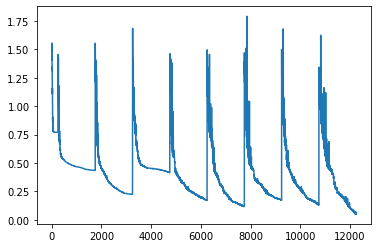

In [14]:
plt.plot(error)

Answering the **bonus question** on the range of theta we need to consider.

If we look at the Rz gate,
$$
R_z(\theta) = \begin{bmatrix}
e^{j\theta/2} & 0 \\
0 & e^{-j\theta/2} 
\end{bmatrix}
$$

This can be rewritten as 
$$
R_z(\theta) = e^{j\theta/2}\begin{bmatrix}
1 & 0 \\
0 & e^{-j\theta}
\end{bmatrix}
$$

This is just an overall phase of just $\theta/2$, and can be neglected, and hence, just sampling $\theta$ from (0,2$\pi$) is sufficient, instead of (0,$4\pi$).

Answering the main **bonus task**, I am running the simulation for another parametrised gate to compare performance.

In [15]:
def evenLayer(circ, layer_num, theta):
  circ.ry(theta[layer_num,0],0)
  circ.ry(theta[layer_num,1],1)
  circ.ry(theta[layer_num,2],2)
  circ.ry(theta[layer_num,3],3)

  #Full entanglement
  circ.cz(0,1)
  circ.cz(0,2)
  circ.cz(0,3)
  circ.cz(1,2)
  circ.cz(1,3)
  circ.cz(2,3)

def oddLayer(circ, layer_num, theta):
  circ.rx(theta[layer_num,0],0)
  circ.rx(theta[layer_num,1],1)
  circ.rx(theta[layer_num,2],2)
  circ.rx(theta[layer_num,3],3)

def createCirc(theta):
  theta2 = theta.reshape((2*N_layer, N_qub))
  qr = q.QuantumRegister(4, name="q")
  cr = q.ClassicalRegister(4, name='c')
  circ = q.QuantumCircuit(qr, cr)
  ##Adding layers
  for i in range(N_layer):
    oddLayer(circ, 2*(i-1),theta2)
    evenLayer(circ, 2*i-1,theta2)
  return circ

(8,) 8
Output Error: 0.910582523474576
(16,) 16
Output Error: 0.4742194065936064
(24,) 24
Output Error: 0.5787052960890016
(32,) 32
Output Error: 0.19930039283120207
(40,) 40
Output Error: 0.12007062755513465
(48,) 48
Output Error: 0.246416507756485
(56,) 56
Output Error: 0.24173870238489828
(64,) 64
Output Error: 0.12240391093837136
(72,) 72
Output Error: 0.1936368092148738


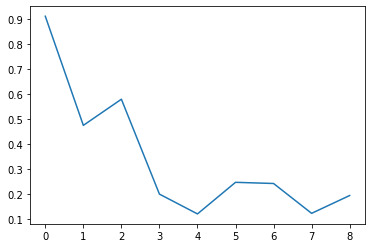

In [16]:
N_qub = 4
target_vec = np.asarray(q.quantum_info.random_statevector(16, seed = 10)._data)
backend = q.Aer.get_backend("statevector_simulator")

N_layer = 1 ##GLOBALLY USED in createCirc function
N_layer_max = 10
max_iter = 1500
#Variable to store error in all the layers, to check convergence
error = []

#Defining the objective function
def objective_function(theta):
    qc = createCirc(theta) #The global N_layer value is used
    result = q.execute(qc, backend).result()
   
    cost = (np.sum((abs(np.asarray(result.get_statevector(qc)) - target_vec))**2))**0.5
    error.append(cost)
    return cost

from qiskit.aqua.components.optimizers import COBYLA

#Array for storing minimum error of each layer
cost_arr = np.zeros((N_layer_max-1,))
optimizer = COBYLA(maxiter=max_iter)

#Running the simulation
while N_layer<N_layer_max:
  #Parameter
  theta = np.random.uniform(0,2*np.pi, (2*N_layer*N_qub))
  print(theta.shape, (2*N_layer*N_qub))
  ret = optimizer.optimize(num_vars=(2*N_layer*N_qub), objective_function=objective_function, initial_point=theta)

  #Getting final result
  qc = createCirc(ret[0])
  result = q.execute(qc, backend).result()
  cost_arr[N_layer-1] = (np.sum((abs(np.asarray(result.get_statevector(qc)) - target_vec))**2))**0.5

  print("Output Error:", ret[1])
  #print("Parameters Found:", ret[0])
  N_layer = N_layer+1
#Plot
plt.plot(cost_arr)

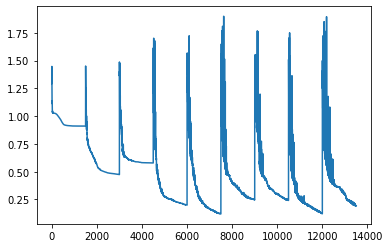

In [17]:
plt.plot(error)